In [1]:
import numpy
import h5py
import tables
import collections
import scipy.sparse as sp_sparse
import scanpy as sc

In [2]:
FeatureBCMatrix = collections.namedtuple('FeatureBCMatrix', ['ids', 'names', 'barcodes', 'matrix'])
def read_10X_h5(filename):
    """Read 10X HDF5 files, support both gene expression and peaks."""
    with tables.open_file(filename, 'r') as f:
        try:
            group = f.get_node(f.root, 'matrix')
        except tables.NoSuchNodeError:
            print("Matrix group does not exist in this file.")
            return None
        feature_group = getattr(group, 'features')
        ids = getattr(feature_group, 'id').read()
        names = getattr(feature_group, 'name').read()
        barcodes = getattr(group, 'barcodes').read()
        data = getattr(group, 'data').read()
        indices = getattr(group, 'indices').read()
        indptr = getattr(group, 'indptr').read()
        shape = getattr(group, 'shape').read()
        matrix = sp_sparse.csc_matrix((data, indices, indptr), shape=shape)
        return FeatureBCMatrix(ids, names, barcodes, matrix)

Load ST data

In [3]:
#Load ST data
st_count_file="./data/realdata/humanheart/Human_heart_ST_gene_count.h5"
st_count = read_10X_h5(st_count_file)
st_count_mat = st_count.matrix.T
st_count_genes = st_count.names.tolist()
st_count_spots = st_count.barcodes.tolist()
if type(st_count_genes[0]) == bytes:
    st_count_genes = [i.decode() for i in st_count_genes]
if type(st_count_spots[0]) == bytes:
    st_count_spots = [i.decode() for i in st_count_spots]
print(st_count_mat.shape)

(3111, 38855)


In [8]:
st_count_dense=st_count_mat.todense()
print(st_count_dense)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [19]:
adata_st = sc.AnnData(X=st_count_dense)
adata_st.obs_names=st_count_spots
adata_st.var_names=st_count_genes

In [21]:
#adata_st.write('./data/realdata/humanheart/Spatial.h5ad')

load SC data

In [22]:
sc_count_file="./data/realdata/humanheart/Human_heart_scRNA_gene_count.h5"
sc_count = read_10X_h5(sc_count_file)
sc_count_mat = sc_count.matrix.T
sc_count_genes = sc_count.names.tolist()
sc_count_cells = sc_count.barcodes.tolist()
if type(sc_count_genes[0]) == bytes:
    sc_count_genes = [i.decode() for i in sc_count_genes]
if type(sc_count_cells[0]) == bytes:
    sc_count_cells = [i.decode() for i in sc_count_cells]

# read cell-type meta file
sc_anno_file="./data/realdata/humanheart/Human_heart_scRNA_celltype_curated.txt"
cell_celltype_dict = {}
for line in open(sc_anno_file, "r"):
    items = line.strip().split("\t")
    cell_celltype_dict[items[0]] = items[1]
print(sc_count_mat.shape)
print(len(sc_count_genes))

(3760, 15323)
15323


In [27]:
sc_count_dense=sc_count_mat.todense()
print(sc_count_dense)

[[ 0.  0.  0. ...  1.  0.  1.]
 [ 0.  0.  0. ... 12.  0. 33.]
 [ 0.  0.  0. ...  3.  0.  7.]
 ...
 [ 0.  0.  0. ... 10.  1. 38.]
 [ 0.  0.  0. ...  7.  0. 11.]
 [ 0.  0.  0. ... 13.  1. 27.]]


In [28]:
adata_sc = sc.AnnData(X=sc_count_dense)
adata_sc.obs_names=sc_count_cells
adata_sc.var_names=sc_count_genes

In [29]:
print(adata_sc)

AnnData object with n_obs × n_vars = 3760 × 15323


In [30]:
adata_sc.obs["celltype"]=cell_celltype_dict.values()

In [33]:
#adata_sc.write('./data/realdata/humanheart/scRNA.h5ad')

visualization

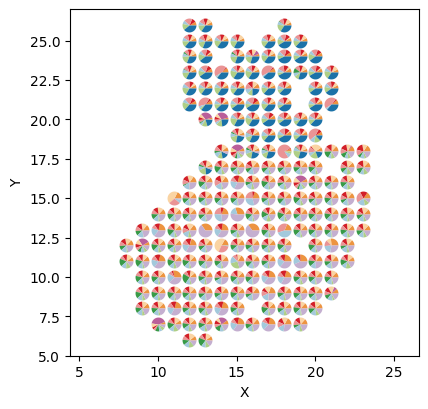

In [78]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def PieMarker(loc_list, frac_list, size, color_list):
    '''
    Return marker list for a point
    '''
    frac_cumsum = np.cumsum(frac_list)
    frac_cumsum = frac_cumsum/frac_cumsum[-1]
    marker_list = []
    previous = 0
    # calculate the points of the pie pieces
    for color, frac in zip(color_list, frac_cumsum):
        curr = frac
        x  = np.cos(2 * np.pi * np.linspace(previous, curr, 50)).tolist()
        y  = np.sin(2 * np.pi * np.linspace(previous, curr, 50)).tolist()
        xy = np.row_stack([[0, 0], np.column_stack([x, y])])
        marker_list.append({'marker': xy, 's': size*np.abs(xy).max()**2, 'facecolor': color, 'edgecolor': "darkgrey", 'linewidth': 0.001})
        previous = frac
    # scatter each of the pie pieces to create pies
    point_marker_list = []
    for marker in marker_list:
        point_marker_list.append(loc_list + [marker])
    return(point_marker_list)

st_loc_file="./data/realdata/humanheart/Human_heart_ST_location.txt"
st_loc_df = pd.read_csv(st_loc_file, sep = "\t", index_col = 0, header = 0)

st_deconv=sc.read_h5ad("./data/realdata/humanheart/coGCN_result2.h5ad")
st_deconv_df = pd.DataFrame(st_deconv.X,index=st_deconv.obs_names,columns=st_deconv.var_names)
st_deconv_df = st_deconv_df.loc[:,np.unique(st_deconv_df.columns)]
st_deconv_df = (st_deconv_df.T/st_deconv_df.sum(axis=1)).T
st_deconv_df = st_deconv_df.fillna(0)
st_loc_df.iloc[:,2] = st_loc_df.iloc[:,2].astype(str)
st_loc_df = st_loc_df[st_loc_df.iloc[:,2] == "19"]
st_deconv_df = st_deconv_df.loc[st_loc_df.index,:]

DefaulfColorPalette = [
    "#643D8E", "#ED9440", "#BA5F9A", "#FAD4A3", "#D31F28", "#EA9495",
    "#389A47", "#A3C9DC", "#AFCF86", "#1B72A8", "#C4AFD0"]
color_pal = DefaulfColorPalette
#pt_size=10
pt_size=10
#pt_size=20
out_prefix="9 PCW(6)"
fig = plt.figure(figsize=(4.5,4.5))
ax = fig.add_subplot()
for i in st_deconv_df.index:
    deconv_list = st_deconv_df.loc[i,:]
    loc_list = st_loc_df.loc[i,:].tolist()
    point_marker_list = PieMarker(loc_list[0:2], deconv_list, pt_size**2, color_pal)

    for point_marker in point_marker_list:
        ax.scatter(point_marker[0], point_marker[1], **point_marker[-1])
# add legends
celltypes = st_deconv_df.columns
patch_list = []
# for i in range(len(celltypes)):
#     patch_list.append(mpatches.Patch(facecolor = color_pal[i], label = celltypes[i], edgecolor = "darkgrey", linewidth=0.01))
# ax.legend(handles = patch_list, loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '12', frameon = False,
#     handlelength=1, handleheight=1)
ax.axis('equal')
#ax.set_ylim(ymin = 14.5, ymax = 23.5)
# ax.set_xlim(xmin = 18, xmax = 26)
ax.set_xlabel(st_loc_df.columns[0])
ax.set_ylabel(st_loc_df.columns[1])
#ax.set_title(out_prefix, pad = 15)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# save figure
#plot_file = os.path.join("./data/realdata/humanheart/", "example.pdf")
# plot_file = os.path.join("./data/realdata/humanheart/", "%s_deconv_scatterpie_plot.pdf" %(out_prefix))
# fig.savefig(plot_file, bbox_inches = "tight")
plt.show(fig)

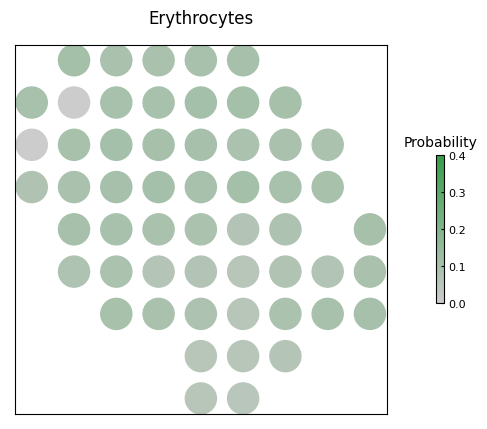

In [214]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

st_loc_file="./data/realdata/humanheart/Human_heart_ST_location.txt"
st_loc_df = pd.read_csv(st_loc_file, sep = "\t", index_col = 0, header = 0)

st_deconv=sc.read_h5ad("./data/realdata/humanheart/pygGCN_result1.h5ad")
st_deconv_df = pd.DataFrame(st_deconv.X,index=st_deconv.obs_names,columns=st_deconv.var_names)
st_deconv_df = st_deconv_df.loc[:,np.unique(st_deconv_df.columns)]
st_deconv_df = (st_deconv_df.T/st_deconv_df.sum(axis=1)).T
st_deconv_df = st_deconv_df.fillna(0)
st_loc_df.iloc[:,2] = st_loc_df.iloc[:,2].astype(str)
st_loc_df = st_loc_df[st_loc_df.iloc[:,2] == "1"]
st_deconv_df = st_deconv_df.loc[st_loc_df.index,:]

crd=np.array(st_loc_df.iloc[:,0:2]).astype(float)

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

c_dict = {'red':  ((0.0, 0.8, 0.8),
                   (1.0, 0.21, 0.21)),

          'green': ((0.0, 0.8, 0.8),
                    (1.0, 0.62, 0.62)),

          'blue':  ((0.0, 0.8, 0.8),
                    (1.0, 0.28, 0.28))
         }

mycolor_cmp = mcolors.LinearSegmentedColormap('mycolor', c_dict)

fig = plt.figure()
ax = fig.add_subplot()
celltypes = sorted(st_deconv_df.columns)
id=6
vmin = 0
vmax = 0.4
points = plt.scatter(x = crd[:,0], y = crd[:,1], 
                c=st_deconv_df.iloc[:, id],cmap = mycolor_cmp,
                alpha=1, s =500,vmin = vmin,vmax = vmax)

fc=fig.colorbar(points,shrink=0.4, pad=0.1)
ax2=fc.ax
ax2.set_title('Probability',fontsize=10)
ax2.tick_params(which='major',direction='in',labelsize=8,length=2.5)
ax2.tick_params(which='minor',direction='in')

#plt.colorbar(shrink=0.4, pad=-0.2,label="Probability")
ax.axis('equal')
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
# for v in ax.axes.spines.values():
#         v.set_edgecolor('none')
ax.set_title(celltypes[id], pad = 15)
plot_file = os.path.join("./data/realdata/humanheart/", "%s_4.5_scatter_plot.pdf" %(celltypes[id]))
fig.savefig(plot_file, bbox_inches = "tight")
plt.show(fig)